# EEG Feature Selection

In [63]:
# EEG Feature Selection
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from scipy import signal
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from mne.decoding import CSP
import json
import os
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
# Set plotting style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style('whitegrid')

# Set random seed for reproducibility
np.random.seed(42)

## 1. Load Dataset
First, let's load the EEG data and split information:

In [39]:
def loadData(
    fold_name: str,
    kfold_dict: dict,
    data_path: str,
    set_suffix: str = "_task-eyesclosed_eeg.set"
):
    """
    Load MNE Raw objects for all training and validation subjects in one fold.
    
    Parameters
    ----------
    fold_name : str
        e.g. 'fold_1', 'fold_2', etc., as found in kfold_dict.
    kfold_dict : dict
        The JSON structure loaded from kfold_splits.json
    data_path : str
        Base directory where the sub-XXX folders are found.
        Typically something like '/path/to/dataset/derivatives'
        if .set files live in a derivatives folder.
    set_suffix : str
        The filename pattern for the EEGLAB .set file, 
        e.g. '_task-eyesclosed_eeg.set'. Adjust as needed.
    
    Returns
    -------
    train_raws : list
        List of mne.io.Raw objects for all training subjects in this fold.
    val_raws : list
        List of mne.io.Raw objects for all validation subjects in this fold.
    """

    fold_data = kfold_dict[fold_name]
    train_subjects = fold_data["train"]
    val_subjects   = fold_data["validation"]

    train_raws = []
    val_raws   = []

    # 1) Load all training subjects
    for subj_id in train_subjects:
        # Construct the filepath to the .set file
        subject_folder = os.path.join(data_path, subj_id, "eeg")
        set_filename   = f"{subj_id}{set_suffix}"
        set_filepath   = os.path.join(subject_folder, set_filename)

        print(f"[{fold_name}] Loading TRAIN subject: {subj_id} -> {set_filepath}")
        raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
        train_raws.append(raw_obj)

    # 2) Load all validation subjects
    for subj_id in val_subjects:
        subject_folder = os.path.join(data_path, subj_id, "eeg")
        set_filename   = f"{subj_id}{set_suffix}"
        set_filepath   = os.path.join(subject_folder, set_filename)

        print(f"[{fold_name}] Loading VAL subject: {subj_id} -> {set_filepath}")
        raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
        val_raws.append(raw_obj)

    return train_raws, val_raws

# Example usage:
if __name__ == "__main__":
    # 0) Load kfold_splits.json
    with open("kfold_splits.json", "r") as f:
        kfold_splits = json.load(f)

    # 1) Choose your data path (where the sub-XXX folders live)
    #    If your .set files are stored in a 'derivatives' folder, use that:
    data_dir = "dataset/derivatives"

    # 2) Load data for fold_1 (as an example)
    fold_name = "fold_1"
    train_raws, val_raws = loadData(
        fold_name=fold_name,
        kfold_dict=kfold_splits,
        data_path=data_dir,
        set_suffix="_task-eyesclosed_eeg.set"
    )

    # Now you have 'train_raws' and 'val_raws' as lists of MNE Raw objects.
    # You can proceed with feature selection or further processing.


[fold_1] Loading TRAIN subject: sub-021 -> dataset/derivatives/sub-021/eeg/sub-021_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-026 -> dataset/derivatives/sub-026/eeg/sub-026_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-019 -> dataset/derivatives/sub-019/eeg/sub-019_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-010 -> dataset/derivatives/sub-010/eeg/sub-010_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-017 -> dataset/derivatives/sub-017/eeg/sub-017_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-028 -> dataset/derivatives/sub-028/eeg/sub-028_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-016 -> dataset/derivatives/sub-016/eeg/sub-016_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-029 -> dataset/derivatives/sub-029/eeg/sub-029_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-011 -> dataset/derivatives/sub-011/eeg/sub-011_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-027 -> dataset/derivatives/sub-027/eeg/sub-027_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-018 -> dataset/derivatives/sub-018/eeg/sub-018_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-020 -> dataset/derivatives/sub-020/eeg/sub-020_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-033 -> dataset/derivatives/sub-033/eeg/sub-033_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-034 -> dataset/derivatives/sub-034/eeg/sub-034_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-035 -> dataset/derivatives/sub-035/eeg/sub-035_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-004 -> dataset/derivatives/sub-004/eeg/sub-004_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-025 -> dataset/derivatives/sub-025/eeg/sub-025_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-014 -> dataset/derivatives/sub-014/eeg/sub-014_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-012 -> dataset/derivatives/sub-012/eeg/sub-012_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-015 -> dataset/derivatives/sub-015/eeg/sub-015_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-023 -> dataset/derivatives/sub-023/eeg/sub-023_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-024 -> dataset/derivatives/sub-024/eeg/sub-024_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-006 -> dataset/derivatives/sub-006/eeg/sub-006_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-001 -> dataset/derivatives/sub-001/eeg/sub-001_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-008 -> dataset/derivatives/sub-008/eeg/sub-008_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-031 -> dataset/derivatives/sub-031/eeg/sub-031_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-036 -> dataset/derivatives/sub-036/eeg/sub-036_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-007 -> dataset/derivatives/sub-007/eeg/sub-007_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-043 -> dataset/derivatives/sub-043/eeg/sub-043_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-044 -> dataset/derivatives/sub-044/eeg/sub-044_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-042 -> dataset/derivatives/sub-042/eeg/sub-042_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-060 -> dataset/derivatives/sub-060/eeg/sub-060_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-058 -> dataset/derivatives/sub-058/eeg/sub-058_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-051 -> dataset/derivatives/sub-051/eeg/sub-051_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-056 -> dataset/derivatives/sub-056/eeg/sub-056_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-057 -> dataset/derivatives/sub-057/eeg/sub-057_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-050 -> dataset/derivatives/sub-050/eeg/sub-050_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-059 -> dataset/derivatives/sub-059/eeg/sub-059_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-061 -> dataset/derivatives/sub-061/eeg/sub-061_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-040 -> dataset/derivatives/sub-040/eeg/sub-040_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-049 -> dataset/derivatives/sub-049/eeg/sub-049_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-048 -> dataset/derivatives/sub-048/eeg/sub-048_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-046 -> dataset/derivatives/sub-046/eeg/sub-046_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-039 -> dataset/derivatives/sub-039/eeg/sub-039_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-037 -> dataset/derivatives/sub-037/eeg/sub-037_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-064 -> dataset/derivatives/sub-064/eeg/sub-064_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-063 -> dataset/derivatives/sub-063/eeg/sub-063_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-038 -> dataset/derivatives/sub-038/eeg/sub-038_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-053 -> dataset/derivatives/sub-053/eeg/sub-053_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-054 -> dataset/derivatives/sub-054/eeg/sub-054_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-062 -> dataset/derivatives/sub-062/eeg/sub-062_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-065 -> dataset/derivatives/sub-065/eeg/sub-065_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-086 -> dataset/derivatives/sub-086/eeg/sub-086_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-072 -> dataset/derivatives/sub-072/eeg/sub-072_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-075 -> dataset/derivatives/sub-075/eeg/sub-075_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-081 -> dataset/derivatives/sub-081/eeg/sub-081_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-080 -> dataset/derivatives/sub-080/eeg/sub-080_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-074 -> dataset/derivatives/sub-074/eeg/sub-074_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-087 -> dataset/derivatives/sub-087/eeg/sub-087_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-067 -> dataset/derivatives/sub-067/eeg/sub-067_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-069 -> dataset/derivatives/sub-069/eeg/sub-069_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-068 -> dataset/derivatives/sub-068/eeg/sub-068_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-066 -> dataset/derivatives/sub-066/eeg/sub-066_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-078 -> dataset/derivatives/sub-078/eeg/sub-078_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-082 -> dataset/derivatives/sub-082/eeg/sub-082_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-085 -> dataset/derivatives/sub-085/eeg/sub-085_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-071 -> dataset/derivatives/sub-071/eeg/sub-071_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-084 -> dataset/derivatives/sub-084/eeg/sub-084_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-083 -> dataset/derivatives/sub-083/eeg/sub-083_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-079 -> dataset/derivatives/sub-079/eeg/sub-079_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading VAL subject: sub-002 -> dataset/derivatives/sub-002/eeg/sub-002_task-eyesclosed_eeg.set
[fold_1] Loading VAL subject: sub-005 -> dataset/derivatives/sub-005/eeg/sub-005_task-eyesclosed_eeg.set
[fold_1] Loading VAL subject: sub-032 -> dataset/derivatives/sub-032/eeg/sub-032_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading VAL subject: sub-003 -> dataset/derivatives/sub-003/eeg/sub-003_task-eyesclosed_eeg.set
[fold_1] Loading VAL subject: sub-022 -> dataset/derivatives/sub-022/eeg/sub-022_task-eyesclosed_eeg.set
[fold_1] Loading VAL subject: sub-013 -> dataset/derivatives/sub-013/eeg/sub-013_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading VAL subject: sub-030 -> dataset/derivatives/sub-030/eeg/sub-030_task-eyesclosed_eeg.set
[fold_1] Loading VAL subject: sub-009 -> dataset/derivatives/sub-009/eeg/sub-009_task-eyesclosed_eeg.set
[fold_1] Loading VAL subject: sub-045 -> dataset/derivatives/sub-045/eeg/sub-045_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading VAL subject: sub-047 -> dataset/derivatives/sub-047/eeg/sub-047_task-eyesclosed_eeg.set
[fold_1] Loading VAL subject: sub-041 -> dataset/derivatives/sub-041/eeg/sub-041_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading VAL subject: sub-055 -> dataset/derivatives/sub-055/eeg/sub-055_task-eyesclosed_eeg.set
[fold_1] Loading VAL subject: sub-052 -> dataset/derivatives/sub-052/eeg/sub-052_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-39-79e62b503a2a>:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading VAL subject: sub-088 -> dataset/derivatives/sub-088/eeg/sub-088_task-eyesclosed_eeg.set
[fold_1] Loading VAL subject: sub-073 -> dataset/derivatives/sub-073/eeg/sub-073_task-eyesclosed_eeg.set
[fold_1] Loading VAL subject: sub-076 -> dataset/derivatives/sub-076/eeg/sub-076_task-eyesclosed_eeg.set
[fold_1] Loading VAL subject: sub-070 -> dataset/derivatives/sub-070/eeg/sub-070_task-eyesclosed_eeg.set
[fold_1] Loading VAL subject: sub-077 -> dataset/derivatives/sub-077/eeg/sub-077_task-eyesclosed_eeg.set


<ipython-input-39-79e62b503a2a>:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


In [29]:
train_raws
sfreq = train_raws[0].info['sfreq']
print("Sampling frequency:", sfreq)

Sampling frequency: 500.0


In [40]:
def extract_epochs_from_raw(raw, duration=1.0, tmin=0.0):
    """
    Extract epochs from a continuous Raw object.
    If no valid events (other than 'boundary') are found,
    fixed-length epochs are created.
    
    Parameters
    ----------
    raw : mne.io.Raw object
        The continuous EEG data.
    duration : float
        Duration (in seconds) of each epoch.
    tmin : float
        Start time relative to the epoch (default is 0).
    
    Returns
    -------
    epochs : mne.Epochs object
        The extracted epochs.
    """
    # Try to extract events from annotations
    events, event_id = mne.events_from_annotations(raw, verbose=False)
    
    if events.size == 0:
        print("No valid events found (only boundaries). Creating fixed-length epochs.")
        # Create fixed-length epochs
        epochs = mne.make_fixed_length_epochs(raw, duration=duration, overlap=0, preload=True)
    else:
        tmax = tmin + duration
        epochs = mne.Epochs(raw, events, event_id, tmin=tmin, tmax=tmax,
                            baseline=None, preload=True, verbose=False)
    return epochs

def extract_epochs_from_all(raw_list, duration=1.0):
    """
    Process a list of Raw objects, extract epochs from each, crop them to have a consistent
    number of time points, and concatenate them.
    
    Parameters
    ----------
    raw_list : list of mne.io.Raw objects
        The list of subjects' EEG data.
    duration : float
        Duration (in seconds) of each epoch.
    
    Returns
    -------
    epochs_all : mne.Epochs object
        Concatenated epochs from all subjects with a consistent time dimension.
    """
    epochs_list = []
    for raw in raw_list:
        epochs = extract_epochs_from_raw(raw, duration=duration)
        sfreq = raw.info['sfreq']
        n_samples_expected = int(sfreq * duration)
        # Crop the data of each epoch to ensure consistent length
        data = epochs.get_data()[:, :, :n_samples_expected]
        # Create a new Epochs object from the cropped data
        new_epochs = mne.EpochsArray(data, epochs.info, events=epochs.events, event_id=epochs.event_id)
        epochs_list.append(new_epochs)
    
    epochs_all = mne.concatenate_epochs(epochs_list)
    return epochs_all

# Process all training subjects with fixed 1-second epochs
epochs_train = extract_epochs_from_all(train_raws, duration=1.0)

# Extract data and labels:
X_train = epochs_train.get_data()      # Shape: (n_trials_total, n_channels, n_samples)
y_train = epochs_train.events[:, -1]     # Labels (event codes) for each epoch

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3 matching events found
No baseli

<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will ch

No valid events found (only boundaries). Creating fixed-length epochs.
Not setting metadata
869 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 869 events and 500 original time points ...
0 bad epochs dropped
Not setting metadata
869 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
6 matching events found
No baseline correction applied
0 projection 

<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will ch

0 bad epochs dropped
Not setting metadata
599 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
No valid events found (only boundaries). Creating fixed-length epochs.
Not setting metadata
829 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 829 events and 500 original time points ...


<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will ch

0 bad epochs dropped
Not setting metadata
829 matching events found
No baseline correction applied
0 projection items activated
No valid events found (only boundaries). Creating fixed-length epochs.
Not setting metadata
881 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 881 events and 500 original time points ...
0 bad epochs dropped
Not setting metadata
881 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]


Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated
No valid events found (only boundaries). Creating fixed-length epochs.
Not setting metadata
796 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 796 events and 500 original time points ...


<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will ch

0 bad epochs dropped
Not setting metadata
796 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
No valid events found (only bo

<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will ch

0 bad epochs dropped
Not setting metadata
777 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
No valid events found (only boundaries). Creating fixed-length epochs.
Not setting metadata
884 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 884 events and 500 original 

<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will ch

0 bad epochs dropped
Not setting metadata
884 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
No valid events found (only boundaries). Creating fixed-length epochs.
Not setting metadata
643 matching events found
No baseline corre

<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will ch

0 bad epochs dropped
Not setting metadata
643 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
No valid events found (only boundaries). Creating fixed-length epochs.
Not setting metadata
777 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 777 events and 500 original time points ...
0 bad epochs dropped


<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will ch

Not setting metadata
777 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
No valid events found (only boundaries). Creating fixed-length epochs.
Not setting metadata
652 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 652 events and 500 original time points ...
0 bad epochs dropped
Not setting metadata
652 matching events found
No baseline correction applied
0 projection items activated
No valid events found (only boundaries). Creating fixed-length epochs.
Not setting metadata
913 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 913 events and 500 original time points ...


<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]


0 bad epochs dropped
Not setting metadata
913 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-40-dc159abd3c63>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]


Not setting metadata
9062 matching events found
No baseline correction applied
X_train shape: (9062, 19, 500)
y_train shape: (9062,)


<ipython-input-40-dc159abd3c63>:69: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_train = epochs_train.get_data()      # Shape: (n_trials_total, n_channels, n_samples)


## 2. Filtering and Preprocessing

In [42]:
def preprocess_raws(raw_list, l_freq=1.0, h_freq=45.0, notch_freq=60):
    """
    Preprocess a list of MNE Raw objects by applying:
      - Bandpass filtering
      - Notch filtering (for line noise)
    
    Parameters
    ----------
    raw_list : list of mne.io.Raw objects
        The list of EEG data to process.
    l_freq : float
        Low frequency cutoff for bandpass filter.
    h_freq : float
        High frequency cutoff for bandpass filter.
    notch_freq : float or list
        Frequency/frequencies at which to apply the notch filter.
    
    Returns
    -------
    filtered_raws : list of mne.io.Raw objects
        The list of filtered Raw objects.
    """
    filtered_raws = []
    
    for raw in raw_list:
        # Make a copy to avoid modifying the original raw object
        raw_copy = raw.copy()
        
        # Apply bandpass filter
        raw_copy.filter(l_freq=l_freq, h_freq=h_freq, method='fir', verbose=False)
        
        # Apply notch filter to remove 60 Hz line noise
        raw_copy.notch_filter(freqs=notch_freq, method='fir', verbose=False)
        
        filtered_raws.append(raw_copy)
    
    return filtered_raws

# Example usage:
filtered_train_raws = preprocess_raws(train_raws, l_freq=1.0, h_freq=45.0)
print(f"Processed {len(filtered_train_raws)} training subjects.")
# Optionally, to see the shape of the filtered data for the first subject:
print(filtered_train_raws[0].get_data().shape)

Processed 70 training subjects.
(19, 460140)


In [43]:
epochs_train_filtered = epochs_train.copy().filter(l_freq=1.0, h_freq=45.0, verbose=False)
X_train_filtered = epochs_train_filtered.get_data()
print("X_train_filtered shape:", X_train_filtered.shape)

<ipython-input-43-0b7761f0d89c>:1: RuntimeWarning: filter_length (1651) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_train_filtered = epochs_train.copy().filter(l_freq=1.0, h_freq=45.0, verbose=False)


X_train_filtered shape: (9062, 19, 500)


<ipython-input-43-0b7761f0d89c>:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_train_filtered = epochs_train_filtered.get_data()


## 3. Frequency Band Power Features

In [55]:
# def extract_band_powers(raw_list, sfreq):
#     """
#     Extract power in standard EEG frequency bands from a list of MNE Raw objects.
    
#     Parameters:
#     raw_list : list of mne.io.Raw objects
#         Each Raw object contains EEG data (n_channels x n_samples).
#     sfreq : float
#         Sampling frequency in Hz.
    
#     Returns:
#     band_powers : numpy array of shape (n_subjects, n_features)
#         Each row contains concatenated band power features for all channels.
#     feature_names : list of str
#         List of feature names corresponding to each channel-band combination.
#     """
#     # Define frequency bands
#     bands = {
#         'delta': (0.5, 4),
#         'theta': (4, 8),
#         'alpha': (8, 13),
#         'beta': (13, 30),
#         'gamma': (30, 45)
#     }
    
#     all_band_powers = []
#     feature_names = []
    
#     # Loop over each subject (raw object)
#     for subject_idx, raw in enumerate(raw_list):
#         eeg_data = raw.get_data()  # shape: (n_channels, n_samples)
#         subject_powers = []
        
#         # Loop over each channel
#         for ch_idx in range(eeg_data.shape[0]):
#             channel_data = eeg_data[ch_idx]
            
#             # Calculate PSD using Welch's method
#             freqs, psd = signal.welch(channel_data, sfreq, nperseg=int(sfreq * 2))
            
#             # Extract band powers for this channel
#             ch_powers = []
#             for band_name, (fmin, fmax) in bands.items():
#                 # Find indices corresponding to the frequency band
#                 idx_band = np.logical_and(freqs >= fmin, freqs <= fmax)
#                 # Calculate average power in the band
#                 band_power = np.mean(psd[idx_band])
#                 ch_powers.append(band_power)
                
#                 # Create feature names only once (for the first subject and first channel)
#                 if subject_idx == 0 and ch_idx == 0:
#                     feature_names.append(f"ch{ch_idx}_{band_name}")
            
#             # Concatenate the band powers of each channel
#             subject_powers.extend(ch_powers)
        
#         all_band_powers.append(subject_powers)
    
#     return np.array(all_band_powers), feature_names

# # Example usage:
# band_powers, power_feature_names = extract_band_powers(filtered_train_raws, sfreq)
# print(f"Band power features shape: {band_powers.shape}")
# print(f"Example features: {power_feature_names[:10]}")

In [56]:
def extract_band_powers_from_array(X, sfreq):
    """
    Extract power in standard EEG frequency bands from a NumPy array.
    
    Parameters
    ----------
    X : numpy array
        EEG data with shape (n_subjects, n_channels, n_samples).
    sfreq : float
        Sampling frequency in Hz.
    
    Returns
    -------
    band_powers : numpy array of shape (n_subjects, n_features)
        Each row contains concatenated band power features for all channels.
    feature_names : list of str
        List of feature names corresponding to each channel-band combination.
    """
    # Define frequency bands
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 45)
    }
    
    all_band_powers = []
    feature_names = []
    
    n_subjects, n_channels, _ = X.shape
    
    # Loop over each subject (row in X)
    for subject_idx in range(n_subjects):
        subject_data = X[subject_idx]  # shape: (n_channels, n_samples)
        subject_powers = []
        
        # Loop over each channel
        for ch_idx in range(subject_data.shape[0]):
            channel_data = subject_data[ch_idx]
            
            # Calculate PSD using Welch's method
            freqs, psd = signal.welch(channel_data, sfreq, nperseg=int(sfreq * 2))
            
            # Extract band powers for this channel
            ch_powers = []
            for band_name, (fmin, fmax) in bands.items():
                # Find indices corresponding to the frequency band
                idx_band = np.logical_and(freqs >= fmin, freqs <= fmax)
                # Calculate average power in the band
                band_power = np.mean(psd[idx_band])
                ch_powers.append(band_power)
                
                # Create feature names only once (for the first subject and first channel)
                if subject_idx == 0 and ch_idx == 0:
                    feature_names.append(f"ch{ch_idx}_{band_name}")
            
            # Concatenate the band powers of each channel
            subject_powers.extend(ch_powers)
        
        all_band_powers.append(subject_powers)
    
    return np.array(all_band_powers), feature_names

# Example usage:
band_powers, power_feature_names = extract_band_powers_from_array(X_train_filtered, sfreq)
print(f"Band power features shape: {band_powers.shape}")
print(f"Example features: {power_feature_names[:10]}")

Band power features shape: (9062, 95)
Example features: ['ch0_delta', 'ch0_theta', 'ch0_alpha', 'ch0_beta', 'ch0_gamma']


## 4. Power Ratios

In [57]:
# def extract_power_ratios(raw_list, sfreq):
#     """
#     Calculate power ratio features from a list of MNE Raw objects.
    
#     Parameters
#     ----------
#     raw_list : list of mne.io.Raw objects
#         Each Raw object contains preprocessed EEG data (n_channels x n_samples).
#     sfreq : float
#         Sampling frequency in Hz.
    
#     Returns
#     -------
#     ratio_features : numpy array of shape (n_subjects, n_features)
#         Each row contains the concatenated power ratio features for all channels.
#     ratio_names : list of str
#         Names for each channel-band ratio feature.
#     """
#     # Define frequency bands
#     bands = {
#         'delta': (0.5, 4),
#         'theta': (4, 8),
#         'alpha': (8, 13),
#         'beta': (13, 30),
#         'gamma': (30, 45)
#     }
    
#     # Define ratios to calculate
#     ratios = [
#         ('theta', 'beta'),     # theta/beta ratio
#         ('alpha', 'theta'),    # alpha/theta ratio
#         ('delta', 'theta'),    # delta/theta ratio
#         ('alpha', 'beta'),     # alpha/beta ratio
#         ('delta', 'alpha'),    # delta/alpha ratio
#     ]
    
#     all_ratios = []
#     ratio_names = []
    
#     for subject_idx, raw in enumerate(raw_list):
#         eeg_data = raw.get_data()  # shape: (n_channels, n_samples)
#         subject_ratios = []
        
#         # Process each channel
#         for ch_idx in range(eeg_data.shape[0]):
#             channel_data = eeg_data[ch_idx]
            
#             # Compute PSD using Welch's method
#             freqs, psd = signal.welch(channel_data, sfreq, nperseg=int(sfreq * 2))
            
#             # Calculate average power in each frequency band
#             band_powers = {}
#             for band_name, (fmin, fmax) in bands.items():
#                 idx_band = np.logical_and(freqs >= fmin, freqs <= fmax)
#                 band_powers[band_name] = np.mean(psd[idx_band])
            
#             # Compute ratios for the channel
#             ch_ratios = []
#             for num_band, denom_band in ratios:
#                 # Avoid division by zero
#                 if band_powers[denom_band] > 0:
#                     ratio = band_powers[num_band] / band_powers[denom_band]
#                 else:
#                     ratio = 0
#                 ch_ratios.append(ratio)
                
#                 # Only create feature names once (for the first subject's first channel)
#                 if subject_idx == 0 and ch_idx == 0:
#                     ratio_names.append(f"ch{ch_idx}_{num_band}_{denom_band}_ratio")
            
#             subject_ratios.extend(ch_ratios)
        
#         all_ratios.append(subject_ratios)
    
#     return np.array(all_ratios), ratio_names

# # Example usage:
# power_ratios, ratio_feature_names = extract_power_ratios(filtered_train_raws, sfreq)
# print(f"Power ratio features shape: {power_ratios.shape}")
# print(f"Example ratio features: {ratio_feature_names[:10]}")

In [91]:
def extract_power_ratios_from_array(X, sfreq):
    """
    Calculate power ratio features from a NumPy array.
    
    Parameters
    ----------
    X : numpy array
        EEG data with shape (n_trials, n_channels, n_samples).
    sfreq : float
        Sampling frequency in Hz.
    
    Returns
    -------
    ratio_features : numpy array of shape (n_trials, n_features)
        Each row contains concatenated power ratio features for all channels.
    ratio_names : list of str
        List of feature names.
    """
    # Define frequency bands
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 45)
    }
    
    # Define ratios to calculate: (numerator band, denominator band)
    ratios = [
        ('theta', 'beta'),     # theta/beta ratio
        ('alpha', 'theta'),    # alpha/theta ratio
        ('delta', 'theta'),    # delta/theta ratio
        ('alpha', 'beta'),     # alpha/beta ratio
        ('delta', 'alpha')     # delta/alpha ratio
    ]
    
    all_ratios = []
    ratio_names = []
    
    n_trials, n_channels, _ = X.shape
    
    for trial_idx in range(n_trials):
        trial_data = X[trial_idx]  # shape: (n_channels, n_samples)
        trial_ratios = []
        for ch_idx in range(n_channels):
            channel_data = trial_data[ch_idx]
            freqs, psd = signal.welch(channel_data, sfreq, nperseg=int(sfreq * 2))
            # Calculate average power for each band
            band_powers = {}
            for band_name, (fmin, fmax) in bands.items():
                idx_band = np.logical_and(freqs >= fmin, freqs <= fmax)
                band_powers[band_name] = np.mean(psd[idx_band])
            ch_ratios = []
            for num_band, denom_band in ratios:
                # Avoid division by zero
                if band_powers[denom_band] > 0:
                    ratio = band_powers[num_band] / band_powers[denom_band]
                else:
                    ratio = 0
                ch_ratios.append(ratio)
                # Create feature names for every channel in the first trial
                if trial_idx == 0:
                    ratio_names.append(f"ch{ch_idx}_{num_band}_{denom_band}_ratio")
            trial_ratios.extend(ch_ratios)
        all_ratios.append(trial_ratios)
    
    return np.array(all_ratios), ratio_names

## 5. Common Spatial Patterns (CSP)

In [67]:
participants['Group'].unique()

array(['A', 'C', 'F'], dtype=object)

In [68]:
# 1. Load the participants file.
participants = pd.read_csv("dataset/participants.tsv", sep="\t")
print(participants.head())

# 2. Create a mapping from participant_id to Group.
group_dict = dict(zip(participants['participant_id'], participants['Group']))
print("Group mapping:", group_dict)

# 3. Create a mapping from group labels to numeric labels.
#    For example, if your groups are "A", "B", "C", this code will assign them 0, 1, 2.
unique_groups = participants['Group'].unique()
print("Unique groups:", unique_groups)
label_map = {group: i for i, group in enumerate(unique_groups)}
print("Label map:", label_map)

# 4. Assume that train_raws is your list of Raw objects.
#    You need a list of subject IDs corresponding to train_raws.
#    For example, if you haven't stored the subject IDs in raw.info, you can manually create one:
train_subject_ids = [f"sub-{i:03d}" for i in range(1, len(train_raws)+1)]
# Alternatively, if raw.info already contains subject info, extract it:
# train_subject_ids = [raw.info.get('subject_id', f"sub-{i:03d}") for i, raw in enumerate(train_raws)]

# 5. Define a function to extract epochs from a Raw object.
def extract_epochs_from_raw(raw, duration=1.0, tmin=0.0):
    """
    Extract epochs from a Raw object. If no valid events (other than 'boundary') are found,
    create fixed-length epochs.
    """
    events, event_id = mne.events_from_annotations(raw, verbose=False)
    if events.size == 0:
        print(f"No valid events for subject {raw.info.get('subject_id', 'unknown')}. Creating fixed-length epochs.")
        epochs = mne.make_fixed_length_epochs(raw, duration=duration, overlap=0, preload=True)
    else:
        tmax = tmin + duration
        epochs = mne.Epochs(raw, events, event_id, tmin=tmin, tmax=tmax,
                            baseline=None, preload=True, verbose=False)
    return epochs

# 6. Loop over each training subject, extract epochs, and assign the clinical label.
all_epochs_list = []
all_labels_list = []

for i, raw in enumerate(train_raws):
    subject_id = train_subject_ids[i]
    if subject_id not in group_dict:
        raise ValueError(f"Group for subject {subject_id} not found in participants.tsv")
    
    group = group_dict[subject_id]
    label = label_map[group]
    
    # Extract epochs (using fixed-length if necessary)
    epochs = extract_epochs_from_raw(raw, duration=1.0)
    
    # Ensure consistent epoch length by cropping each epoch to exactly duration seconds.
    sfreq = raw.info['sfreq']
    n_samples_expected = int(sfreq * 1.0)
    data = epochs.get_data()[:, :, :n_samples_expected]
    new_epochs = mne.EpochsArray(data, epochs.info, events=epochs.events, event_id=epochs.event_id)
    
    all_epochs_list.append(new_epochs)
    # Create an array of labels for all epochs from this subject.
    subject_labels = np.full(new_epochs.get_data().shape[0], label)
    all_labels_list.append(subject_labels)

# 7. Concatenate epochs and labels from all subjects.
epochs_all = mne.concatenate_epochs(all_epochs_list)
X_train = epochs_all.get_data()       # shape: (n_total_trials, n_channels, n_samples)
y_train = np.concatenate(all_labels_list)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Unique labels in y_train:", np.unique(y_train))

  participant_id Gender  Age Group  MMSE
0        sub-001      F   57     A    16
1        sub-002      F   78     A    22
2        sub-003      M   70     A    14
3        sub-004      F   67     A    20
4        sub-005      M   70     A    22
Group mapping: {'sub-001': 'A', 'sub-002': 'A', 'sub-003': 'A', 'sub-004': 'A', 'sub-005': 'A', 'sub-006': 'A', 'sub-007': 'A', 'sub-008': 'A', 'sub-009': 'A', 'sub-010': 'A', 'sub-011': 'A', 'sub-012': 'A', 'sub-013': 'A', 'sub-014': 'A', 'sub-015': 'A', 'sub-016': 'A', 'sub-017': 'A', 'sub-018': 'A', 'sub-019': 'A', 'sub-020': 'A', 'sub-021': 'A', 'sub-022': 'A', 'sub-023': 'A', 'sub-024': 'A', 'sub-025': 'A', 'sub-026': 'A', 'sub-027': 'A', 'sub-028': 'A', 'sub-029': 'A', 'sub-030': 'A', 'sub-031': 'A', 'sub-032': 'A', 'sub-033': 'A', 'sub-034': 'A', 'sub-035': 'A', 'sub-036': 'A', 'sub-037': 'C', 'sub-038': 'C', 'sub-039': 'C', 'sub-040': 'C', 'sub-041': 'C', 'sub-042': 'C', 'sub-043': 'C', 'sub-044': 'C', 'sub-045': 'C', 'sub-046': 'C', 's

<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current defau

Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current defau

Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
No valid events for subject unknown. Creating fixed-length epochs.
Not setting metadata
869 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 869 events and 500 original time points ...


<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)


0 bad epochs dropped
Not setting metadata
869 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current defau

Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current defau

Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
No valid events for subject unknown. Creating fixed-length epochs.
Not setting metadata
599 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 599 events and 500 original time points ...


<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)


0 bad epochs dropped
Not setting metadata
599 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
No valid events for subject unknown. Creating fixed-length epochs.
Not setting metadata
829 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 829 events and 500 original time points ...


<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current defau

0 bad epochs dropped
Not setting metadata
829 matching events found
No baseline correction applied
0 projection items activated
No valid events for subject unknown. Creating fixed-length epochs.
Not setting metadata
881 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 881 events and 500 original time points ...


<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)


0 bad epochs dropped
Not setting metadata
881 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current defau

Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated
No valid events for subject unknown. Creating fixed-length epochs.
Not setting metadata
796 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 796 events and 500 original time points ...


<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)


0 bad epochs dropped
Not setting metadata
796 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current defau

Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
No valid events for subject unknown. Creating fixed-length epochs.
Not setting metadata
777 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 777 events and 500 original time points ...


<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current defau

0 bad epochs dropped
Not setting metadata
777 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current defau

Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
No valid events for subject unknown. Creating fixed-length epochs.
Not setting metadata
884 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 884 events and 500 original time points ...


<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)


0 bad epochs dropped
Not setting metadata
884 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
4 matching events found
No baseline correction applied


<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current defau

0 projection items activated
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
No valid events for subject unknown. Creating fixed-length epochs.
Not setting metadata
643 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 643 events and 500 original time points ...


<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current defau

0 bad epochs dropped
Not setting metadata
643 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
No valid events for subject unknown. Creating fixed-length epochs.
Not setting metadata
777 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 777 events and 500 original time points ...


<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current defau

0 bad epochs dropped
Not setting metadata
777 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
No valid events for subject unknown. Creating fixed-length epochs.
Not setting metadata
652 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 652 events and 500 original time points ...


<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current defau

0 bad epochs dropped
Not setting metadata
652 matching events found
No baseline correction applied
0 projection items activated
No valid events for subject unknown. Creating fixed-length epochs.
Not setting metadata
913 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 913 events and 500 original time points ...


<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)


0 bad epochs dropped
Not setting metadata
913 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-68-39eb3f5ba9d4>:57: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-68-39eb3f5ba9d4>:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)


Not setting metadata
9062 matching events found
No baseline correction applied
X_train shape: (9062, 19, 500)
y_train shape: (9062,)
Unique labels in y_train: [0 1 2]


<ipython-input-68-39eb3f5ba9d4>:67: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_train = epochs_all.get_data()       # shape: (n_total_trials, n_channels, n_samples)


In [70]:
def extract_csp_features(X, y, n_components=4):
    """
    Extract features using Common Spatial Patterns
    
    Parameters:
    X : array of EEG data with shape (n_subjects, n_channels, n_samples)
    y : array of labels
    n_components : number of CSP components to extract
    
    Returns:
    csp_features : array of CSP features
    csp : fitted CSP object
    """
    # Initialize CSP
    csp = CSP(n_components=n_components, reg=None, log=True, norm_trace=False)
    
    # Fit and transform
    csp_features = csp.fit_transform(X, y)
    
    # Create feature names
    feature_names = [f"CSP_{i}" for i in range(n_components)]
    
    return csp_features, feature_names, csp

In [71]:
unique_labels = np.unique(y_train)
print("Unique labels in y_train:", unique_labels)

Unique labels in y_train: [0 1 2]


## 6. Combine Features and Evaluate

In [92]:
# Assuming X_train_filtered has shape (n_trials, n_channels, n_samples)
# and y_train has length n_trials

# Extract band power features from array (already defined similarly)
band_powers, power_feature_names = extract_band_powers_from_array(X_train_filtered, sfreq)
print(f"Band power features shape: {band_powers.shape}")

# Extract power ratio features from array (using our modified function)
power_ratios, ratio_feature_names = extract_power_ratios_from_array(X_train_filtered, sfreq)
print(f"Power ratio features shape: {power_ratios.shape}")

# Extract CSP features
# Note: CSP expects at least two classes in y_train.
n_trials = X_train_filtered.shape[0]
# Create dummy labels: first half 0, second half 1.
dummy_y = np.zeros(n_trials, dtype=int)
dummy_y[n_trials // 2:] = 1

# Use dummy_y for CSP:
csp_features, csp_feature_names, csp = extract_csp_features(X_train_filtered, y_train, n_components=4)
print(f"CSP features shape: {csp_features.shape}")
print(f"CSP feature names: {csp_feature_names}")

csp_features, csp_feature_names, csp = extract_csp_features(X_train_filtered, y_train, n_components=4)
print(f"CSP features shape: {csp_features.shape}")

# Now, all three arrays should have the same number of rows (n_trials).
print("Combined rows:", band_powers.shape[0], power_ratios.shape[0], csp_features.shape[0])

# Combine features along the feature axis (axis=1)
combined_features = np.hstack((band_powers, power_ratios, csp_features))
all_feature_names = power_feature_names + ratio_feature_names + csp_feature_names
print(f"Combined features shape: {combined_features.shape}")


/Users/shreya_sudan/opt/anaconda3/lib/python3.8/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 1000 is greater than input length  = 500, using nperseg = 500
  warnings.warn('nperseg = {0:d} is greater than input length '


Band power features shape: (9062, 95)
Power ratio features shape: (9062, 95)
Computing rank from data with rank=None
    Using tolerance 0.0006 (2.2e-16 eps * 19 dim * 1.4e+11  max singular value)
    Estimated rank (mag): 19
    MAG: rank 19 computed from 19 data channels with 0 projectors
Reducing data rank from 19 -> 19
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00052 (2.2e-16 eps * 19 dim * 1.2e+11  max singular value)
    Estimated rank (mag): 19
    MAG: rank 19 computed from 19 data channels with 0 projectors
Reducing data rank from 19 -> 19
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00034 (2.2e-16 eps * 19 dim * 8e+10  max singular value)
    Estimated rank (mag): 19
    MAG: rank 19 computed from 19 data channels with 0 projectors
Reducing data rank from 19 -> 19
Estimating covariance using EMPIRICAL
Done.
CSP features shape: (9062, 4)
CSP feature names

In [93]:
def evaluate_features(X, y, n_folds=5):
    """
    Evaluate feature set using cross-validation with a Random Forest classifier.
    
    Parameters
    ----------
    X : numpy array
        Feature array with shape (n_trials, n_features).
    y : numpy array
        Label array (length n_trials).
    n_folds : int
        Number of cross-validation folds.
    
    Returns
    -------
    scores : numpy array
        Accuracy scores from cross-validation.
    """
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_val_score(clf, X, y, cv=n_folds, scoring='accuracy')
    return scores


In [94]:
# Compute accuracy scores for each feature type
band_scores   = evaluate_features(band_powers, y_train)
ratio_scores  = evaluate_features(power_ratios, y_train)
csp_scores    = evaluate_features(csp_features, y_train)
all_scores    = evaluate_features(combined_features, y_train)


In [95]:
selector = SelectKBest(f_classif, k=20)
X_selected = selector.fit_transform(combined_features, y_train)

In [96]:
selected_scores = evaluate_features(X_selected, y_train)

In [97]:
all_feature_names

['ch0_delta',
 'ch0_theta',
 'ch0_alpha',
 'ch0_beta',
 'ch0_gamma',
 'ch1_delta',
 'ch1_theta',
 'ch1_alpha',
 'ch1_beta',
 'ch1_gamma',
 'ch2_delta',
 'ch2_theta',
 'ch2_alpha',
 'ch2_beta',
 'ch2_gamma',
 'ch3_delta',
 'ch3_theta',
 'ch3_alpha',
 'ch3_beta',
 'ch3_gamma',
 'ch4_delta',
 'ch4_theta',
 'ch4_alpha',
 'ch4_beta',
 'ch4_gamma',
 'ch5_delta',
 'ch5_theta',
 'ch5_alpha',
 'ch5_beta',
 'ch5_gamma',
 'ch6_delta',
 'ch6_theta',
 'ch6_alpha',
 'ch6_beta',
 'ch6_gamma',
 'ch7_delta',
 'ch7_theta',
 'ch7_alpha',
 'ch7_beta',
 'ch7_gamma',
 'ch8_delta',
 'ch8_theta',
 'ch8_alpha',
 'ch8_beta',
 'ch8_gamma',
 'ch9_delta',
 'ch9_theta',
 'ch9_alpha',
 'ch9_beta',
 'ch9_gamma',
 'ch10_delta',
 'ch10_theta',
 'ch10_alpha',
 'ch10_beta',
 'ch10_gamma',
 'ch11_delta',
 'ch11_theta',
 'ch11_alpha',
 'ch11_beta',
 'ch11_gamma',
 'ch12_delta',
 'ch12_theta',
 'ch12_alpha',
 'ch12_beta',
 'ch12_gamma',
 'ch13_delta',
 'ch13_theta',
 'ch13_alpha',
 'ch13_beta',
 'ch13_gamma',
 'ch14_delta',

In [98]:
print("Band power names:", len(power_feature_names))      # Expected: 95
print("Power ratio names:", len(ratio_feature_names))       # Expected: 95
print("CSP feature names:", len(csp_feature_names))         # Expected: 4
print("Total feature names:", len(all_feature_names))       # Expected: 194
print("Combined features shape:", combined_features.shape)


Band power names: 95
Power ratio names: 95
CSP feature names: 4
Total feature names: 194
Combined features shape: (9062, 194)


In [99]:
selected_indices = selector.get_support(indices=True)
selected_features = [all_feature_names[i] for i in selected_indices]

print("Top 20 features selected by ANOVA F-test:")
for i, feature in enumerate(selected_features):
    print(f"{i+1}. {feature}")

Top 20 features selected by ANOVA F-test:
1. ch0_beta
2. ch0_gamma
3. ch2_beta
4. ch2_gamma
5. ch8_alpha
6. ch9_alpha
7. ch12_beta
8. ch12_gamma
9. ch13_beta
10. ch13_gamma
11. ch14_alpha
12. ch15_alpha
13. ch8_alpha_beta_ratio
14. ch9_alpha_beta_ratio
15. ch14_alpha_beta_ratio
16. ch15_alpha_beta_ratio
17. CSP_0
18. CSP_1
19. CSP_2
20. CSP_3


## 7. Feature Selection Summary

In [100]:
# Create lists for feature type names and the corresponding mean accuracies and standard deviations.
feature_types = ['Band Powers', 'Power Ratios', 'CSP', 'Selected 20', 'All Combined']

accuracies = [
    np.mean(band_scores),
    np.mean(ratio_scores),
    np.mean(csp_scores),
    np.mean(selected_scores),
    np.mean(all_scores)
]

std_devs = [
    np.std(band_scores),
    np.std(ratio_scores),
    np.std(csp_scores),
    np.std(selected_scores),
    np.std(all_scores)
]

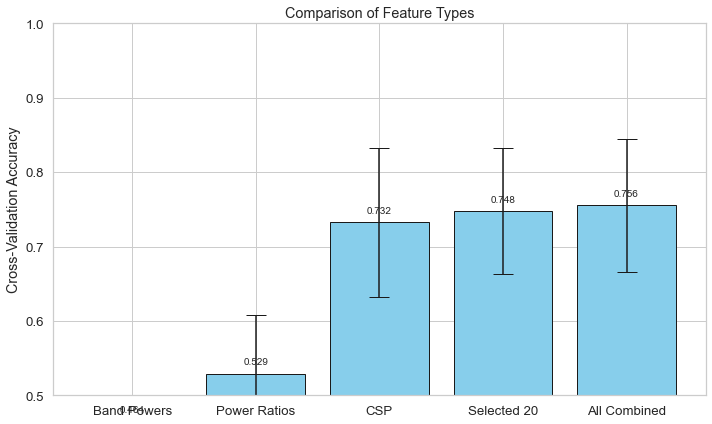

In [101]:
# ----- Visualization: Bar Plot -----
plt.figure(figsize=(10, 6))
bars = plt.bar(feature_types, accuracies, yerr=std_devs, capsize=10, color='skyblue', edgecolor='k')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Comparison of Feature Types')
plt.ylim(0.5, 1.0)  # Adjust y-axis limits as needed

# Add numeric labels on the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


<ipython-input-102-d8323256feb5>:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


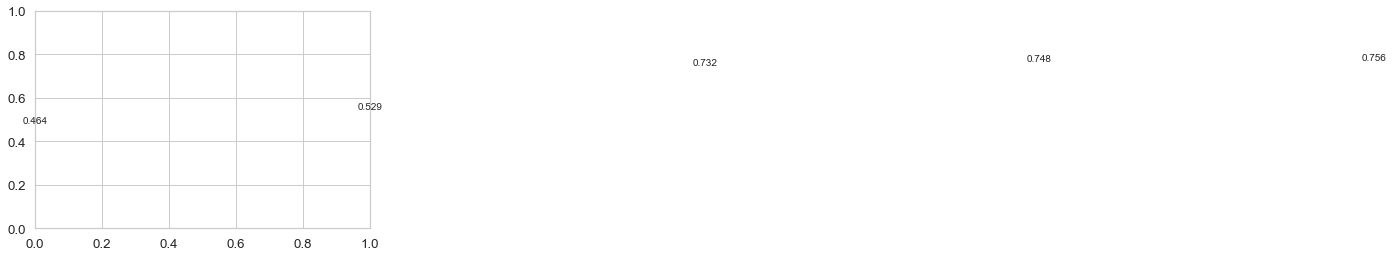

In [102]:
# Add numeric labels on the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [103]:
# ----- Visualization: Boxplot of Accuracy Scores -----
# Create a dictionary with accuracy scores for each feature type
accuracy_data = {
    'Band Powers': band_scores,
    'Power Ratios': ratio_scores,
    'CSP': csp_scores,
    'Selected 20': selected_scores,
    'All Combined': all_scores
}

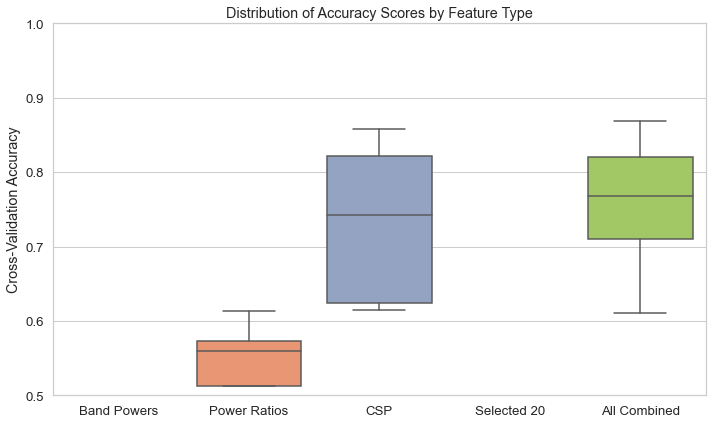

In [85]:
# Convert the dictionary into a DataFrame for easier plotting
boxplot_data = pd.DataFrame(accuracy_data)
plt.figure(figsize=(10, 6))
sns.boxplot(data=boxplot_data, palette="Set2")
plt.ylabel('Cross-Validation Accuracy')
plt.title('Distribution of Accuracy Scores by Feature Type')
plt.ylim(0.5, 1.0)
plt.tight_layout()
plt.show()


In [104]:
results_df = pd.DataFrame({
    'Feature Type': feature_types,
    'Number of Features': [band_powers.shape[1],
                           power_ratios.shape[1],
                           csp_features.shape[1],
                           20,
                           combined_features.shape[1]],
    'Mean Accuracy': accuracies,
    'Std Dev': std_devs
})

print("Feature Selection Summary:")
print(results_df)

Feature Selection Summary:
   Feature Type  Number of Features  Mean Accuracy   Std Dev
0   Band Powers                  95       0.464467  0.000205
1  Power Ratios                  95       0.528800  0.078577
2           CSP                   4       0.732411  0.099635
3   Selected 20                  20       0.747518  0.084888
4  All Combined                 194       0.755576  0.089645


In [105]:
with open('selected_features.txt', 'w') as f:
    f.write("Selected features by ANOVA F-test:\n")
    for feature in selected_features:
        f.write(f"{feature}\n")
    
    f.write("\nTop features by Random Forest importance:\n")
    for feature in selected_features:  # assuming top_features is already defined
        f.write(f"{feature}\n")

print("\nSelected features saved to 'selected_features.txt'")



Selected features saved to 'selected_features.txt'
